# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Задачи

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Задачи:**
- Построить наулучшую модель для предсказания объема продукции скважины руководствуясь метрикой RMSE;
- С помощью модели по технике Bootstrap оценить в каком регионе добыча принесет наибольшую прибыль.

# Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import scipy.stats as st

# Загрузка и подготовка данных

**Описание данных:**
- Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv, geo_data_2.csv.
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [2]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')
data_0.name = 'Регион 0'
data_1.name = 'Регион 1'
data_2.name = 'Регион 2'

In [3]:
def whats_inside(data):
    print(f'\t**** {data.name} ***')
    print(data.info())
    display(data.describe())
    display(data.head())
    print(f'Всего дубликатов = {data.duplicated().sum()}')
    print()
    return None

In [4]:
for data in [data_0, data_1, data_2]:
    whats_inside(data)

	**** Регион 0 ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Всего дубликатов = 0

	**** Регион 1 ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Всего дубликатов = 0

	**** Регион 2 ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Всего дубликатов = 0



Из чего видно, что:
- для кажого региона параметры f0, f1 и f2 колеблются в различных пределах (и учитывая то как мало о них сказанно, они вообще могут быть различными показателями в разных регионах), так что для каждого региона будет необходимо обучить отельную модель;
- пропусков нет;
- дубликатов нет.

Для будущих предсказаний id скважины неважен. Идентификатором уникальной скважины будет служить индекс колонки в таблице.

In [5]:
for data in [data_0, data_1, data_2]:
    data.drop('id', axis=1, inplace=True)

# Обучение и проверка модели

In [6]:
results = {}
for data in [data_0, data_1, data_2]:
    results[data.name] = {}
    
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=24) # Разбивка на выборки
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid) # Работа модели
    
    rmse = (mean_squared_error(target_valid, prediction))**0.5
    mean_product = prediction.mean() # Оценка модели
    
    results[data.name]['Обученная модель'] = model
    results[data.name]['Предсказания'] = pd.Series(prediction, index=target_valid.index)
    results[data.name]['Правильные ответы'] = target_valid
    results[data.name]['RMSE'] = rmse
    results[data.name]['Cредний запас предсказанного сырья'] = mean_product

In [7]:
for key, value in results.items():
    print(f'\t*** {key} ***')
    for k, v in value.items():
        if k in ['RMSE', 'Cредний запас предсказанного сырья']:
            print(f'{k} = {v}')
    print()

	*** Регион 0 ***
RMSE = 37.81479466757922
Cредний запас предсказанного сырья = 92.4464681623946

	*** Регион 1 ***
RMSE = 0.8916379508287229
Cредний запас предсказанного сырья = 68.41051634077131

	*** Регион 2 ***
RMSE = 40.226046329423475
Cредний запас предсказанного сырья = 94.84406173360135



По результатам можно заметить, что RMSE для модели региона №1 очень низок по сравнению с другими моделями. В чем причина столь высокой точности? Можно попробовать проверить корреляции.

	*** Регион 0 ***


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


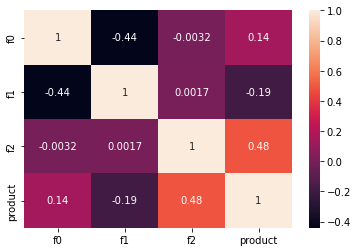


	*** Регион 1 ***


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


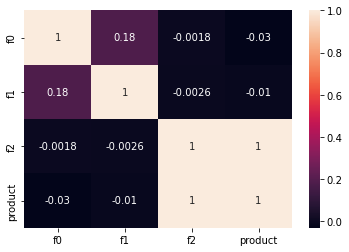


	*** Регион 2 ***


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


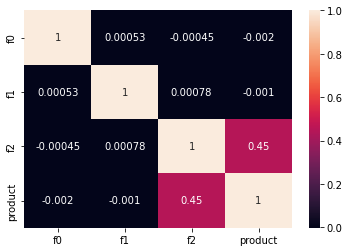

In [8]:
for data in [data_0, data_1, data_2]:
    print(f'\t*** {data.name} ***')
    display(data.corr())
    sns.heatmap(data.corr(), annot=True)
    plt.show()
    print()

Можно увидеть, для всех регионов давольно характерна более высокая корреляция между f2 и product. Однако в регионе №1 эта корелляция почти достигает единицы. Возможности доказать/опровергнуть утечку целевого признака в f2 в данном случае нет. Значит можно просто принять этот признак за высококоррелирующий с целевым и радоваться точности предсказаний.

# Подготовка к расчёту прибыли

In [9]:
OIL_WELL_SCOUTED = 500 # Количество скважин при разведке
OIL_WELL_BUILT = 200 # Количество скважин для разработки
COST_PER_UNIT = 450000 # unit = 1000 barrels
BUDGET = 10000000000

Достаточный средний объём сырья с одной скважины для безубыточной разработки будет расчитываться как:
$$ \frac {Бюджет} {Стоимость\ за\ единицу\ сырья * Количество\ скважин\ для\ разработки} $$

In [10]:
needed_mean_production = BUDGET / (COST_PER_UNIT * OIL_WELL_BUILT)
print('Достаточный средний объём сырья с одной скважины для безубыточной разработки =', needed_mean_production)

Достаточный средний объём сырья с одной скважины для безубыточной разработки = 111.11111111111111


In [11]:
for data in (data_0, data_1, data_2):
    print(f'Реальный средний объем сырья со скважины в {data.name} =', data['product'].mean())

Реальный средний объем сырья со скважины в Регион 0 = 92.49999999999974
Реальный средний объем сырья со скважины в Регион 1 = 68.82500000002561
Реальный средний объем сырья со скважины в Регион 2 = 95.00000000000041


Из чего видно, что в среднем скважины не обладают достаточным обьемом продукта, чтобы окупить затраты на свою разработку.

Однако если проверить TOP-200 скважин каждого региона:

In [12]:
for data in (data_0, data_1, data_2):
    best_oil_wells = data['product'].sort_values(ascending=False).iloc[:OIL_WELL_BUILT]
    print(f'Реальный средний объем сырья с TOP-200 лучших скважин в {data.name} =', best_oil_wells.mean())

Реальный средний объем сырья с TOP-200 лучших скважин в Регион 0 = 184.83373964536023
Реальный средний объем сырья с TOP-200 лучших скважин в Регион 1 = 137.94540774090612
Реальный средний объем сырья с TOP-200 лучших скважин в Регион 2 = 189.55147698176654


То видно, что разработка только лучших скважин может обеспечить окупаемость компании.

# Расчёт прибыли и рисков 

Прибыль будет расчитываться по формуле: $ (Суммарный\ объем\ продукции\ от\ 200\ лучших\ скважин * Цена\ единицы\ объема) - Бюджет $

Риск убытков рассчитывается как: $ \frac {Количество\ убыточных\ выборок} {Общее\ количество\ выборок} $

Прибыль рассчитывается для 200 лучших скважин из 500 скважин выбранных случайным образом.

In [13]:
def income_eval (prediction, target, cost, n_oil_well, budget):
    '''
    Берет n_oil_well лучших предсказаний и из соответсвующих им реальных данных рассчитывает прибыль.
    Важно чтобы prediction и target имели одинаковую индексацию.
    '''
    predicted_best = prediction.sort_values(ascending=False).iloc[:n_oil_well]
    real_income = target.loc[predicted_best.index]
    income = real_income.sum() * cost - budget
    return income

In [14]:
for k in results:
    income = []
    random_p = RandomState(24)
    random_t = RandomState(24) # Два одинаковых RandomState необходимы для того, чтобы в качестве subsample выбирались одинаковые выборки как из предсказаний, так и из правильных ответов
    
    prediction = results[k]['Предсказания']
    target = results[k]['Правильные ответы']
    for _ in range(1000):
        prediction_subsample = prediction.sample(n=OIL_WELL_SCOUTED, replace=True, random_state=random_p)
        target_subsample = target.sample(n=OIL_WELL_SCOUTED, replace=True, random_state=random_t)
        income.append(income_eval(prediction_subsample, target_subsample, COST_PER_UNIT, OIL_WELL_BUILT, BUDGET))
    income = pd.Series(income)
    
    loss_risk = income[income < 0].count() / income.count()
    
    results[k]['Средняя прибыль'] = income.mean()
    results[k]['95%-й доверительный интервал'] = st.t.interval(alpha=.95, df=len(income)-1, loc=income.mean(), scale=income.sem())
    results[k]['Риск убытков'] = loss_risk

In [15]:
for key, value in results.items():
    print(f'\t*** {key} ***')
    for k, v in value.items():
        if k in ['Средняя прибыль', '95%-й доверительный интервал']:
            print(f'{k} = {v}')
        if k == 'Риск убытков':
            print(f'{k} = {v:.2%}')
    print()

	*** Регион 0 ***
Средняя прибыль = 651564611.5495917
95%-й доверительный интервал = (632955365.1138272, 670173857.9853561)
Риск убытков = 0.80%

	*** Регион 1 ***
Средняя прибыль = 644016235.9563988
95%-й доверительный интервал = (628033202.5528064, 659999269.3599913)
Риск убытков = 0.10%

	*** Регион 2 ***
Средняя прибыль = 597854087.629322
95%-й доверительный интервал = (576976539.6275196, 618731635.6311245)
Риск убытков = 3.30%



# Вывод

Согласно условию *"После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью"* нам подходит **Регион №0**. Так как риск убытков для него сотавляет 0.8%, а средняя прибыль является самой большой среди других регионов проходящих по условию вероятности убытков.